In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
from gensim import corpora, models, similarities
import os
import utility_synopsis
import math
import numpy as np
from numpy import linalg as la
from scipy.spatial.distance import cosine
import pandas as pd
import matplotlib.pyplot as plt

2017-02-26 10:41:19,276 : INFO : 'pattern' package not found; tag filters are not available for English


In [2]:
def extract_item_info(filename, delimiter, genre_delimiter):
    data = {}

    with open(filename , 'r') as f:
        for i, line in enumerate(f):
            itemId, title, genre_list = map(lambda x: x.strip(), line.split(delimiter))
            
            data[itemId] = (title, genre_list.split(genre_delimiter))
    return data

In [3]:
item_file_name, item_file_delimiter, genre_delimiter = os.path.sep.join(['ml-1m', 'movies.dat']), '::', '|'
item_info = extract_item_info(item_file_name, item_file_delimiter, genre_delimiter)

In [4]:
def extract_user_item_interaction(filename, delimiter):
    data = {}

    with open(filename , 'r') as f:
        for i, line in enumerate(f):
            userId, movieId, rating, timestamp = line.split(delimiter)
            #userId = int(userId)
            #movieId = int(movieId)
            rating = float(rating)
            timestamp = int(timestamp)

            if userId not in data:
                data[userId] = []
            data[userId].append((movieId, rating, timestamp))
    
    # order by time
    for userId in data:
        data[userId].sort(key=lambda x: x[2]) 
    return data

In [5]:
rating_file_name, rating_file_delimiter = os.path.sep.join(['ml-1m', 'ratings.dat']), '::'
user_item_interaction = extract_user_item_interaction(rating_file_name, rating_file_delimiter)

In [6]:
model_path = '/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model'

#model = gensim.models.Word2Vec.load('/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=200_min_count=5_window=2.model' )
model = gensim.models.Word2Vec.load(model_path)

2017-02-26 10:41:29,818 : INFO : loading Word2Vec object from /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model
2017-02-26 10:41:29,827 : INFO : loading wv recursively from /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model.wv.* with mmap=None
2017-02-26 10:41:29,827 : INFO : setting ignored attribute syn0norm to None
2017-02-26 10:41:29,828 : INFO : setting ignored attribute cum_table to None
2017-02-26 10:41:29,828 : INFO : loaded /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model


In [7]:
def user_history2user_repr__simple_average(model, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    #print 'target_user_history:', target_user_history
    items_existed_in_model = filter(lambda x: x[0] in model, target_user_history)
    #print 'items_existed_in_model:', items_existed_in_model[0]
    items_translated_to_vecs = map(lambda x: model[x[0]], items_existed_in_model)
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    return np.average(items_translated_to_vecs, axis=0)   

#user_history2user_repr__simple_average(model, user_item_interaction['5989'])   

In [ ]:
def user_history2user_repr__rating_average(model, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    #print 'target_user_history:', target_user_history
    items_existed_in_model = filter(lambda x: x[0] in model, target_user_history)
    #print 'items_existed_in_model:', items_existed_in_model[0]
    items_translated_to_vecs = map(lambda x: (model[x[0]], x[1], x[2]), items_existed_in_model)
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    items_multiplied_by_rate = map(lambda (vec, rate, timestamp): vec * rate, items_translated_to_vecs)
    #print 'items_multiplied_by_rate:', items_multiplied_by_rate[0]
    #raw_input()
    
    ## method 1: simple average. not normalized.
    #return np.average(items_multiplied_by_rate, axis=0)   

    # method 2: average with normalization
    items_multiplied_by_rate = np.sum(items_multiplied_by_rate, axis=0)
    items_multiplied_by_rate = items_multiplied_by_rate / sum([x[1] for x in items_translated_to_vecs])
    return items_multiplied_by_rate

In [9]:
user_item_interaction.keys()[:10]

['5988',
 '5989',
 '5982',
 '5983',
 '5980',
 '5981',
 '5986',
 '5987',
 '5984',
 '5985']

In [19]:
user_item_interaction['5989']

[('587', 5.0, 956873919),
 ('588', 5.0, 956873786),
 ('1', 5.0, 956874124),
 ('2', 4.0, 956874389),
 ('3005', 5.0, 957756760),
 ('3006', 3.0, 957756760),
 ('597', 5.0, 956873975),
 ('3053', 5.0, 957756905),
 ('2421', 4.0, 956872639),
 ('2424', 4.0, 956872639),
 ('3408', 5.0, 956873163),
 ('3438', 2.0, 956874389),
 ('231', 3.0, 956873942),
 ('1848', 4.0, 956874389),
 ('3450', 4.0, 956873721),
 ('3466', 4.0, 956874124),
 ('258', 2.0, 956874389),
 ('3477', 3.0, 956873833),
 ('2827', 4.0, 957756905),
 ('3484', 5.0, 956873220),
 ('2829', 1.0, 957756760),
 ('3489', 5.0, 956874389),
 ('1895', 4.0, 956873833),
 ('2840', 4.0, 957756905),
 ('2858', 5.0, 956873659),
 ('2860', 4.0, 957756905),
 ('1126', 4.0, 956874389),
 ('2881', 4.0, 957756760),
 ('2162', 4.0, 956874389),
 ('3114', 5.0, 956873626),
 ('1537', 4.0, 956873659),
 ('3157', 4.0, 956873626),
 ('1583', 3.0, 956874389),
 ('3512', 5.0, 956873163),
 ('3513', 4.0, 956873204),
 ('1920', 2.0, 956874389),
 ('317', 4.0, 956874389),
 ('3536', 5.0

In [8]:
# calculate user representation dict
user_repr = {user: user_history2user_repr__simple_average(model, user_item_interaction[user]) for user in user_item_interaction}

In [18]:
for v in user_item_interaction:
    print v
    print target_repr.dot(user_repr[v]) / (la.norm(target_repr * la.norm(user_repr[v])))
    break

5988


ValueError: operands could not be broadcast together with shapes (3,) (100,) 

In [9]:
K = 10

target_user = '5989'

target_repr = user_repr[target_user]
print target_repr
simi = [(v, target_repr.dot(user_repr[v]) / (la.norm(target_repr * la.norm(user_repr[v]))))
        for v in user_item_interaction]
simi.sort(key=lambda x: -1 * x[1])
print simi[1:K + 1]
print simi[-1 * K:]

[-0.0525671  -0.00347659  0.05366097  0.03172919 -0.01554101 -0.11202001
  0.02124754 -0.06516416  0.09627298  0.02335213  0.06398613  0.02175878
 -0.01147079 -0.04573168  0.03238851 -0.05446875 -0.04143469 -0.04115115
  0.01393058  0.00653823 -0.01295745  0.09508686 -0.01442458  0.03615925
  0.03653627 -0.04835363  0.08032246 -0.10284358  0.07215083  0.05253587
 -0.01647562 -0.00426723 -0.05997043 -0.08835787  0.02151575 -0.01506171
  0.0206341   0.05903862 -0.04361663  0.07431083 -0.00048015 -0.01096276
 -0.04745726  0.02253854  0.04510251  0.00839828 -0.00653884 -0.07195072
 -0.00348398 -0.01955164  0.02194257  0.02703838  0.07907628  0.02849249
  0.0609887  -0.03295216  0.06624562 -0.03270533 -0.03992524  0.03760018
  0.03704993  0.01079769  0.02141699 -0.10356307  0.07455056  0.0141111
 -0.0385832  -0.07655956 -0.0621629  -0.01318503  0.02751966 -0.00400472
 -0.00464505 -0.08583028  0.03799522 -0.01994832  0.00792384  0.03634366
  0.05705244  0.03815703 -0.11672572  0.01809123  0.

In [10]:
set_target = set([x[0] for x in user_item_interaction[target_user]])
set_candy = set([x[0] for x in user_item_interaction[simi[1][0]]])
set_most_dissimilar_candy = set([x[0] for x in user_item_interaction[simi[-1][0]]])

In [36]:
[x[0] for x in user_item_interaction[target_user]]

['587',
 '588',
 '1',
 '2',
 '3005',
 '3006',
 '597',
 '3053',
 '2421',
 '2424',
 '3408',
 '3438',
 '231',
 '1848',
 '3450',
 '3466',
 '258',
 '3477',
 '2827',
 '3484',
 '2829',
 '3489',
 '1895',
 '2840',
 '2858',
 '2860',
 '1126',
 '2881',
 '2162',
 '3114',
 '1537',
 '3157',
 '1583',
 '3512',
 '3513',
 '1920',
 '317',
 '3536',
 '339',
 '3555',
 '21',
 '2907',
 '351',
 '39',
 '367',
 '374',
 '60',
 '2959',
 '2961',
 '708',
 '2996',
 '1265',
 '788',
 '3238',
 '1641',
 '3253',
 '3273',
 '2628',
 '440',
 '2302',
 '2321',
 '2324',
 '2355',
 '1721',
 '2394',
 '2395',
 '2396',
 '1747',
 '3354',
 '1750',
 '1777',
 '1784',
 '2762',
 '2771',
 '1042',
 '551',
 '558']

In [12]:
# This metric might be of interest.
print len(set_target.intersection(set_candy))
print len(set_target.union(set_candy))
print len(set_target.intersection(set_candy)) * 1. / len(set_target.union(set_candy))
print
print len(set_target.intersection(set_most_dissimilar_candy))
print len(set_target.union(set_most_dissimilar_candy))
print len(set_target.intersection(set_most_dissimilar_candy)) * 1. / len(set_target.union(set_most_dissimilar_candy))

39
399
0.0977443609023

0
102
0.0


In [13]:
# find out genres of items in a cluster
def find_out_genres_of_items_interacted_by_a_user(user_item_interaction, user, item_info):
    item_genres_list = []
    for item_id in [x[0] for x in user_item_interaction[user]]:
        #print item_id
        #print item_info[item_id]
        item_genres_list.append((item_id, [','.join(item_info[item_id][1])]))
    return item_genres_list



In [14]:
# find out genre distribution for items belonging to a single cluster
def find_genre_dist(item_genres_list):
    #print item_genres_list
    dist_dist = reduce(lambda x, y: (None, x[1] + y[1]), item_genres_list)
    dist_dist = dist_dist[1]
    dist_dist = [x.split(',') for x in dist_dist]
    dist_dist = reduce(lambda x, y: x + y, dist_dist)
    
    genre_set = set(dist_dist)
    genre_unique_list = list(genre_set)
    
    dist = [(x, list(dist_dist).count(x)) for x in genre_unique_list]
    dist.sort(key=lambda x: -1 * x[1])
    
    count_sum = sum([x[1] for x in dist])
    dist = [(x[0], x[1] * 1. / count_sum) for x in dist]
    return dist

target_igl = find_out_genres_of_items_interacted_by_a_user(user_item_interaction, target_user, item_info)
target_genre_dist = find_genre_dist(target_igl)

In [15]:
candy_user = '1173'
candy_igl = find_out_genres_of_items_interacted_by_a_user(user_item_interaction, candy_user, item_info)
candy_genre_dist = find_genre_dist(candy_igl)

In [16]:
all_genres = [
    "Action", 
    "Adventure", 
    "Animation", 
    "Children's", 
    "Comedy", 
    "Crime", 
    "Documentary", 
    "Drama", 
    "Fantasy", 
    "Film-Noir", 
    "Horror", 
    "Musical", 
    "Mystery", 
    "Romance", 
    "Sci-Fi", 
    "Thriller", 
    "War", 
    "Western", 
]

In [23]:

def plot_genre_dist_of_2_user(target_genre_dist, candy_genre_dist, all_genres):
    d0 = dict(target_genre_dist)
    d1 = dict(candy_genre_dist)

    for g in all_genres:
        if g not in d0:
            d0[g] = 0
    for g in all_genres:
        if g not in d1:
            d1[g] = 0
    assert(set(d0.keys()) == set(d1.keys()))

    d0_list = [d0[x] for x in all_genres]
    d1_list = [d1[x] for x in all_genres]

    d0_list_copy = d0_list[:]
    d0_list = np.array(d0_list) * 1. / sum(d0_list)

    d1_list_copy = d1_list[:]
    d1_list = np.array(d1_list) * 1. / sum(d1_list)

    print d0_list
    print d1_list
    print d0_list - d1_list
    print 'A metric which might be of interest:'
    print math.sqrt(sum((d0_list - d1_list) ** 2) * 1. / len(d0_list)) # This might be a metric of interest.

#    indexes = np.arange(len(all_genres))
#    
#    plt.bar(indexes - 0.2, d0_list, 0.2)
#    plt.bar(indexes + 0.2, d1_list, 0.2)
#
#    fig = plt.gcf()
#    fig.set_size_inches(18.5, 10.5, forward=True)
#
#    plt.show()
    
    ##
    tmp = zip(*[d0_list, d1_list])
    df2 = pd.DataFrame(tmp, columns=['a', 'b'], index=all_genres)

    df2.plot.bar()
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)

    plt.show()
    


[ 0.04216867  0.06024096  0.04216867  0.10843373  0.27710843  0.0060241   0.
  0.12048193  0.10240964  0.          0.0060241   0.01807229  0.0060241
  0.10240964  0.03012048  0.06626506  0.01204819  0.        ]
[ 0.10122699  0.02453988  0.00613497  0.01226994  0.28067485  0.03527607
  0.00306748  0.23619632  0.00613497  0.00153374  0.01687117  0.00920245
  0.01226994  0.11042945  0.0291411   0.09509202  0.01840491  0.00153374]
[-0.05905832  0.03570109  0.03603371  0.0961638  -0.00356641 -0.02925198
 -0.00306748 -0.11571439  0.09627467 -0.00153374 -0.01084707  0.00886984
 -0.00624584 -0.00801981  0.00097938 -0.02882696 -0.00635672 -0.00153374]
0.0471531322716


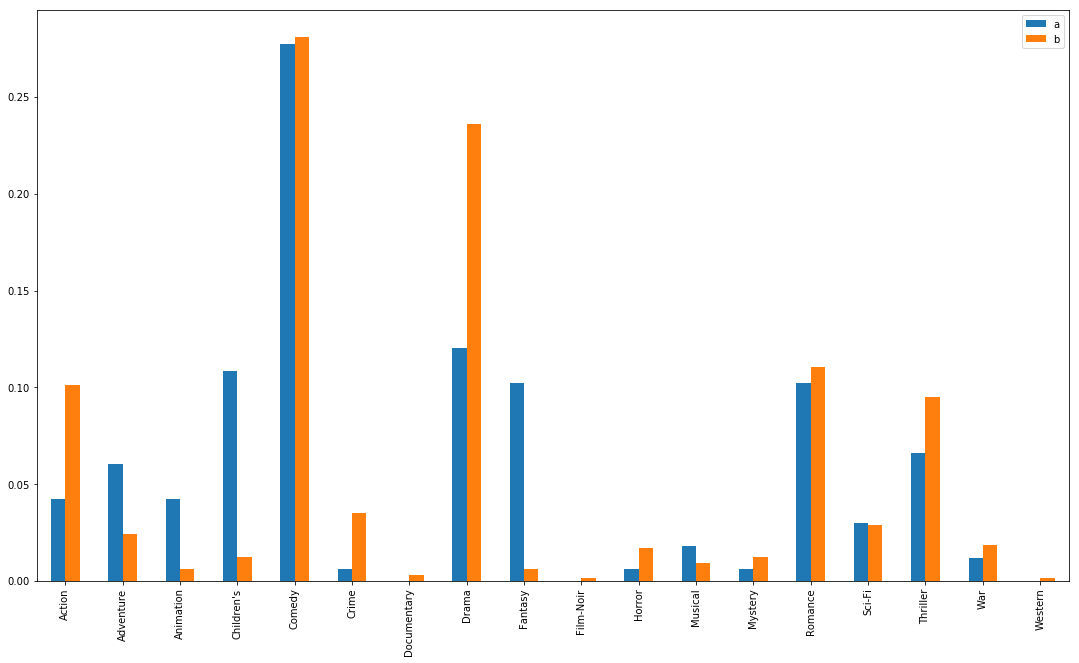

[ 0.04216867  0.06024096  0.04216867  0.10843373  0.27710843  0.0060241   0.
  0.12048193  0.10240964  0.          0.0060241   0.01807229  0.0060241
  0.10240964  0.03012048  0.06626506  0.01204819  0.        ]
[ 0.          0.          0.          0.          0.03448276  0.13793103
  0.          0.10344828  0.          0.34482759  0.          0.
  0.12068966  0.01724138  0.01724138  0.20689655  0.01724138  0.        ]
[ 0.04216867  0.06024096  0.04216867  0.10843373  0.24262568 -0.13190694
  0.          0.01703365  0.10240964 -0.34482759  0.0060241   0.01807229
 -0.11466556  0.08516826  0.0128791  -0.14063149 -0.00519319  0.        ]
0.121478992688


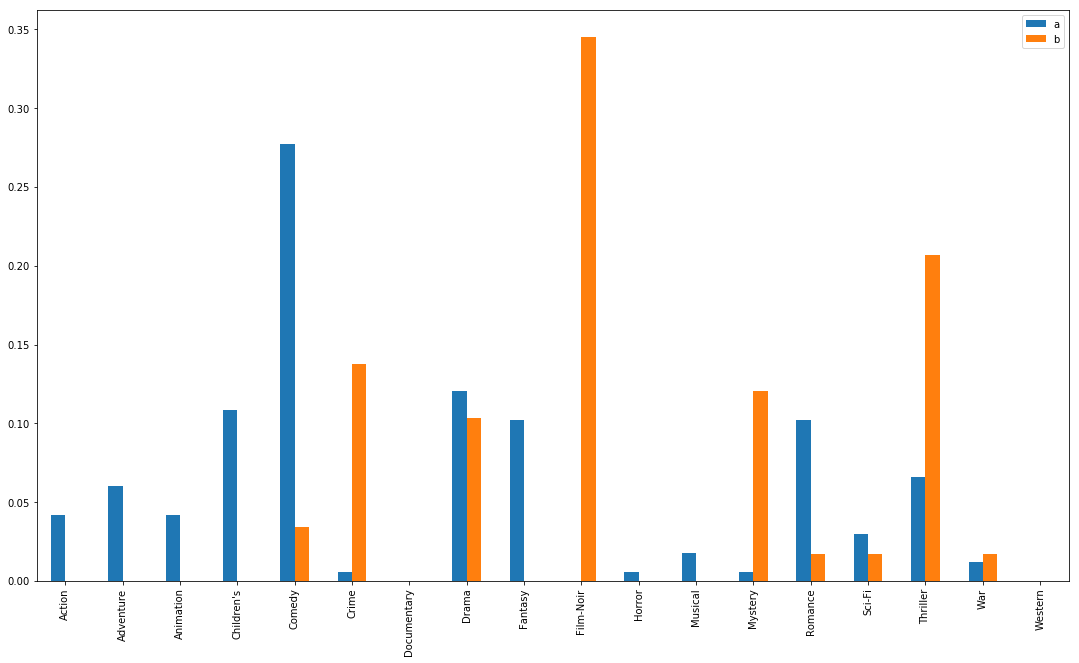

In [24]:
plot_genre_dist_of_2_user(target_genre_dist, candy_genre_dist, all_genres)
most_dissimilar_candy = '5069'
most_dissimilar_candy_igl = find_out_genres_of_items_interacted_by_a_user(user_item_interaction, most_dissimilar_candy, item_info)
most_dissimilar_candy_genre_dist = find_genre_dist(most_dissimilar_candy_igl)
plot_genre_dist_of_2_user(target_genre_dist, most_dissimilar_candy_genre_dist, all_genres)